<a href="https://colab.research.google.com/github/PUBPOL-2130/notebooks/blob/main/Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
%pip install matplotlib pandas us census

%config InlineBackend.figure_formats = ["svg"]

import matplotlib.pyplot as plt
import pandas as pd

from census import Census
from us import states

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
import colorcet as cc

from census import Census

Note: you may need to restart the kernel to use updated packages.


In [3]:
census = Census("", year=2020)

# Week 2: Exploring the U.S. Census, part 1 (population data)

In this notebook, we'll explore the most famous and essential dataset published by the U.S. Census Bureau: the decennial enumeration of the U.S. population. This enumeration is [required by Article I of the U.S. Constitution](https://www.census.gov/programs-surveys/decennial-census/about/census-constitution.html), and the challenges of processing Census data as the national population grew throughout the 19th century led to the development of [a tabulating machine](https://www.computerhistory.org/revolution/punched-cards/2/2) that was [first used for processing the 1890 U.S. Census](https://www.smithsonianmag.com/smithsonian-institution/herman-holleriths-tabulating-machine-2504989/). This machine read punched cards that encoded Census responses and generated summary statistics (such as the number of foreign-born children under 18 in a particular state, or the number of married women in a particular city). The company that developed this tabulating machine was later renamed to IBM.

The technical demands of analyzing U.S. Census data were therefore a catalyst in the early development of computing; in the 130 years or so since the dawn of this automated tabulation technology, Census data has become exponentially more detailed and accessible. Here, we'll focus on a small slice of the 2010 and 2020 decennial Census data published online via the [Census API](https://www.census.gov/data/developers/data-sets.html).


<img width="600" alt="Herman Hollerith's tabulating machine" src="https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/arc/cf/ul/g/a6/a6/hollerithtabulator_sorter.component.simple-narrative-nocrop-xl-retina.ts=1702922330895.jpg/content/adobe-cms/us/en/history/punched-card-tabulator/jcr:content/root/table_of_contents/body/content_section_styled/content-section-body/simple_narrative/image">

_Herman Hollerith's tabulating machine for the 1890 U.S. Census (photo credit: [IBM](https://www.ibm.com/history/punched-card-tabulator))._



## Fetching population data

Here, we'll retrieve population statistics by race from the Census API for all counties in New York. Census data releases are organized into tables; [Table P1](https://data.census.gov/table/DECENNIALPL2020.P1?g=040XX00US36) breaks down population by racial category. For ease of use, we'll map the column names returned by the Census API to their corresponding racial categories: for instance, the `P1_004N` column corresponds to Black population. (Full column definitions are available in the [API documentation](https://api.census.gov/data/2020/dec/pl/variables.html).)

In [5]:
p1_population_columns = {
    "P1_003N": "white",	      # White alone
    "P1_004N": "black",	      # Black or African American alone
    "P1_005N": "amin",        # American Indian and Alaska Native alone
    "P1_006N": "asian",       # Asian alone
    "P1_007N": "nhpi",        # Native Hawaiian and Other Pacific Islander alone
    "P1_008N": "other",       # Some Other Race alone
    "P1_009N": "two_or_more", # Two or more races
}

When fetching data from the Census API, we usually identify geographic regions (states, counties, etc.) by their [FIPS code](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code). For instance, the FIPS code for the state of New York is 36. The `us` package exposes identifiers (FIPS codes, postal abbreviations) for the U.S. states.

In [7]:
state = states.NY

In [9]:
print(state, state.abbr, state.fips)

New York NY 36


Here, we specify:
* The columns we want to fetch from the Census API (the `NAME` column, and the 7 columns from Table P1 listed in `p1_population_columns` above).
* The regions we want to fetch column values for (all counties in New York).

In [12]:
county_populations = census.pl.get(
    ("NAME", *p1_population_columns),
    geo={
        "for": "county:*",
        "in": f"state:{state.fips}",
    }
)

**Note: there are several ways to modify the above code to get data for *multiple* counties and *multiple* states.**

For example, if you want to get data for multiple counties you can simply list them out by their FIPS codes.

```
county_populations = census.pl.get(
    ("NAME", *p1_population_columns),
    geo={
        "for": "county:001,002,003",
        "in": f"state:{state.fips}",
    }
)
```

Or, if you want to get data for all counties in *multiple states* you can list out the states by their FIPS codes.

```
county_populations = census.pl.get(
    ("NAME", *p1_population_columns),
    geo={
        "for": "county:*",
        "in": "state:01,02",
    }
)
```

The syntax `f"state:{state.fips}"` is a kind of [string formatting](https://docs.python.org/3/tutorial/inputoutput.html) in Python, which allows you to dynamically change the content of the string based on other defined variables (in this case, `state.fips`). You can alternatively replace this code with the hard-coded FIPS values (e.g., `"state:01"`).

Lastly, remember that the asterisk `*` allows you to select *all* values corresponding to either counties or states.

The Census API returns a list of dictionaries; each contains column values for a county.

In [15]:
county_populations[0]

{'NAME': 'Albany County, New York',
 'P1_003N': 215496.0,
 'P1_004N': 43206.0,
 'P1_005N': 845.0,
 'P1_006N': 24473.0,
 'P1_007N': 183.0,
 'P1_008N': 8873.0,
 'P1_009N': 21772.0,
 'state': '36',
 'county': '001'}

We can convert this raw response to a Pandas `DataFrame` without any further manipulation.

In [17]:
race_df = pd.DataFrame(county_populations)

In [18]:
race_df.head(5)

,NAME,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N,P1_009N,state,county
0,"Albany County, New York",215496.0,43206.0,845.0,24473.0,183.0,8873.0,21772.0,36,001
1,"Allegany County, New York",42555.0,829.0,91.0,379.0,9.0,678.0,1915.0,36,003
2,"Bronx County, New York",207573.0,487118.0,21539.0,69559.0,1640.0,493052.0,192173.0,36,005
3,"Broome County, New York",158674.0,12684.0,556.0,9372.0,84.0,3975.0,13338.0,36,007
4,"Cattaraugus County, New York",68128.0,1043.0,2706.0,567.0,14.0,571.0,4013.0,36,009


## Postprocessing

We can make `race_df` more usable by applying our mapping from raw column names to human-readable racial categories. We don't need the state and county FIPS codes returned by the Census API by default in the `state` and `county` columns, so we'll drop those columns.

In [24]:
race_df = race_df.rename(
    columns={"NAME": "name", **p1_population_columns}
).drop(
    columns=["state", "county"]
).set_index("name")

In [26]:
race_df.head(10)

,white,black,amin,asian,nhpi,other,two_or_more
name,,,,,,,
"Albany County, New York",215496.0,43206.0,845.0,24473.0,183.0,8873.0,21772.0
"Allegany County, New York",42555.0,829.0,91.0,379.0,9.0,678.0,1915.0
"Bronx County, New York",207573.0,487118.0,21539.0,69559.0,1640.0,493052.0,192173.0
"Broome County, New York",158674.0,12684.0,556.0,9372.0,84.0,3975.0,13338.0
"Cattaraugus County, New York",68128.0,1043.0,2706.0,567.0,14.0,571.0,4013.0
"Cayuga County, New York",67017.0,2910.0,310.0,385.0,54.0,1033.0,4539.0
"Chautauqua County, New York",109333.0,3354.0,673.0,818.0,57.0,4278.0,9144.0
"Chemung County, New York",70463.0,5315.0,240.0,1432.0,15.0,947.0,5736.0
"Chenango County, New York",43531.0,357.0,126.0,245.0,15.0,353.0,2593.0


We can sum the values in each column to compute population totals by racial category for the state.

In [29]:
race_df.sum(axis=0)

white          11143349.0
black           2986172.0
amin             149690.0
asian           1933127.0
nhpi              10815.0
other           2210633.0
two_or_more     1767463.0
dtype: float64

Similarly, we can sum the values in each row to compute population totals (across all racial categories) for each county.

In [32]:
race_df.sum(axis=1)

name
Albany County, New York          314848.0
Allegany County, New York         46456.0
Bronx County, New York          1472654.0
Broome County, New York          198683.0
Cattaraugus County, New York      77042.0
                                  ...    
Washington County, New York       61302.0
Wayne County, New York            91283.0
Westchester County, New York    1004457.0
Wyoming County, New York          40531.0
Yates County, New York            24774.0
Length: 62, dtype: float64

### Visualizing demographics with a pie chart

We can visualize the demographic breakdown of a particular county with [Pandas' pie chart function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.pie.html).

In [36]:
race_df

,white,black,amin,asian,nhpi,other,two_or_more
name,,,,,,,
"Albany County, New York",215496.0,43206.0,845.0,24473.0,183.0,8873.0,21772.0
"Allegany County, New York",42555.0,829.0,91.0,379.0,9.0,678.0,1915.0
"Bronx County, New York",207573.0,487118.0,21539.0,69559.0,1640.0,493052.0,192173.0
"Broome County, New York",158674.0,12684.0,556.0,9372.0,84.0,3975.0,13338.0
"Cattaraugus County, New York",68128.0,1043.0,2706.0,567.0,14.0,571.0,4013.0
...,...,...,...,...,...,...,...
"Washington County, New York",55162.0,1715.0,174.0,326.0,23.0,703.0,3199.0
"Wayne County, New York",80476.0,2562.0,263.0,487.0,15.0,1667.0,5813.0
"Westchester County, New York",533150.0,141094.0,7466.0,65707.0,339.0,146911.0,109790.0


In [38]:
race_df.T

name,"Albany County, New York","Allegany County, New York","Bronx County, New York","Broome County, New York","Cattaraugus County, New York","Cayuga County, New York","Chautauqua County, New York","Chemung County, New York","Chenango County, New York","Clinton County, New York",...,"Sullivan County, New York","Tioga County, New York","Tompkins County, New York","Ulster County, New York","Warren County, New York","Washington County, New York","Wayne County, New York","Westchester County, New York","Wyoming County, New York","Yates County, New York"
white,215496.0,42555.0,207573.0,158674.0,68128.0,67017.0,109333.0,70463.0,43531.0,70142.0,...,56040.0,44557.0,78657.0,141728.0,59911.0,55162.0,80476.0,533150.0,36046.0,23264.0
black,43206.0,829.0,487118.0,12684.0,1043.0,2910.0,3354.0,5315.0,357.0,3060.0,...,6814.0,452.0,4597.0,11063.0,799.0,1715.0,2562.0,141094.0,1999.0,161.0
amin,845.0,91.0,21539.0,556.0,2706.0,310.0,673.0,240.0,126.0,285.0,...,418.0,75.0,353.0,829.0,170.0,174.0,263.0,7466.0,98.0,49.0
asian,24473.0,379.0,69559.0,9372.0,567.0,385.0,818.0,1432.0,245.0,975.0,...,1597.0,379.0,10532.0,3860.0,753.0,326.0,487.0,65707.0,218.0,93.0
nhpi,183.0,9.0,1640.0,84.0,14.0,54.0,57.0,15.0,15.0,26.0,...,29.0,18.0,47.0,63.0,1.0,23.0,15.0,339.0,6.0,10.0
other,8873.0,678.0,493052.0,3975.0,571.0,1033.0,4278.0,947.0,353.0,1010.0,...,6168.0,399.0,2855.0,8390.0,497.0,703.0,1667.0,146911.0,594.0,250.0
two_or_more,21772.0,1915.0,192173.0,13338.0,4013.0,4539.0,9144.0,5736.0,2593.0,4345.0,...,7558.0,2575.0,8699.0,15918.0,3606.0,3199.0,5813.0,109790.0,1570.0,947.0


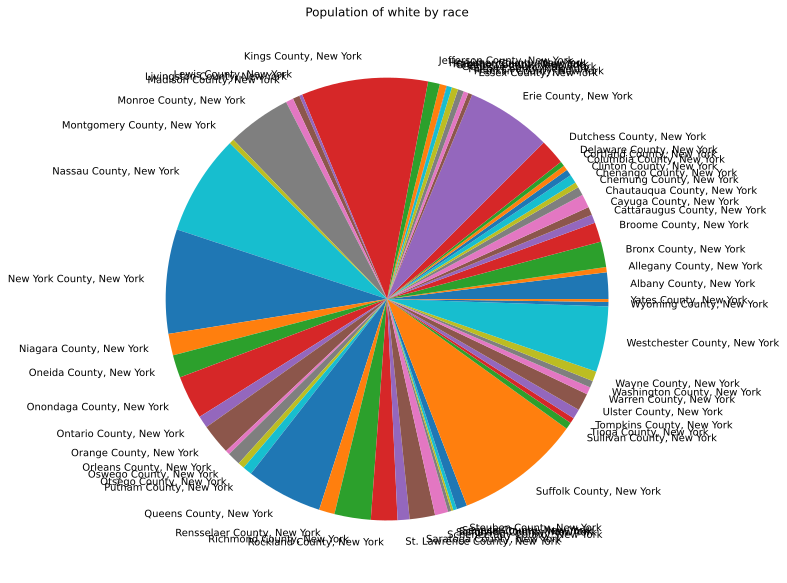

In [40]:
county = "Tompkins County, New York"
county = "white"
ax = race_df.plot.pie(y=county, figsize=(10, 10), legend=False)
ax.set_title(f"Population of {county} by race")
ax.set_ylabel("")
plt.show()

We can visualize the demographic breakdown of the whole state in a similar fashion: first, we compute total population by race for the entire state (as illustrated in the section above), and then we plot the resulting Pandas `Series`. This pie chart improves on the county-level pie chart above by showing percentages for each racial category (rounded to the nearest 0.1%).

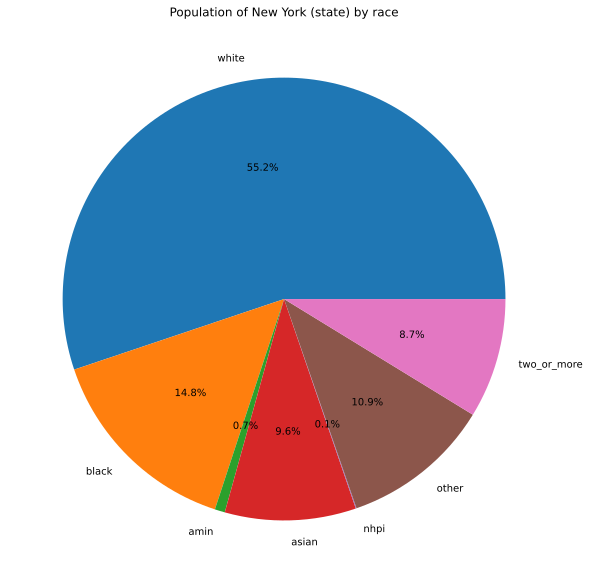

In [43]:
ax = race_df.sum(axis=0).plot.pie(figsize=(10, 10), autopct="%1.1f%%")
ax.set_ylabel("")
ax.set_title(f"Population of {state} (state) by race")
plt.show()

### Computing percentages

In order to answer questions like "which county in New York has the largest _share_ of Black population?", it's necessary to convert absolute population counts to percentages. To do this, it's convenient to compute a `total` column, then create percentage columns by dividing each race column by the `total` column, then scaling by 100 to convert from fractional values to percentages. Pandas' vector arithmetic functionality makes these operations relatively simple to write: rather than explicitly iterating through each row, we can simply write the multiplication and division operations in terms of columns. The operations will be applied to each row!

In [47]:
race_df["total"] = race_df.sum(axis=1)

In [49]:
race_df.head(5)

,white,black,amin,asian,nhpi,other,two_or_more,total
name,,,,,,,,
"Albany County, New York",215496.0,43206.0,845.0,24473.0,183.0,8873.0,21772.0,314848.0
"Allegany County, New York",42555.0,829.0,91.0,379.0,9.0,678.0,1915.0,46456.0
"Bronx County, New York",207573.0,487118.0,21539.0,69559.0,1640.0,493052.0,192173.0,1472654.0
"Broome County, New York",158674.0,12684.0,556.0,9372.0,84.0,3975.0,13338.0,198683.0
"Cattaraugus County, New York",68128.0,1043.0,2706.0,567.0,14.0,571.0,4013.0,77042.0


In [51]:
categories = list(p1_population_columns.values())
categories

['white', 'black', 'amin', 'asian', 'nhpi', 'other', 'two_or_more']

In [53]:
for col in categories:
    race_df[f"{col}_pct"] = 100 * race_df[col] / race_df["total"]

In [55]:
race_df

,white,black,amin,asian,nhpi,other,two_or_more,total,white_pct,black_pct,amin_pct,asian_pct,nhpi_pct,other_pct,two_or_more_pct
name,,,,,,,,,,,,,,,
"Albany County, New York",215496.0,43206.0,845.0,24473.0,183.0,8873.0,21772.0,314848.0,68.444456,13.722812,0.268383,7.772957,0.058123,2.818185,6.915083
"Allegany County, New York",42555.0,829.0,91.0,379.0,9.0,678.0,1915.0,46456.0,91.602807,1.784484,0.195884,0.815826,0.019373,1.459445,4.122180
"Bronx County, New York",207573.0,487118.0,21539.0,69559.0,1640.0,493052.0,192173.0,1472654.0,14.095164,33.077559,1.462597,4.723377,0.111364,33.480505,13.049433
"Broome County, New York",158674.0,12684.0,556.0,9372.0,84.0,3975.0,13338.0,198683.0,79.862897,6.384039,0.279843,4.717062,0.042278,2.000674,6.713206
"Cattaraugus County, New York",68128.0,1043.0,2706.0,567.0,14.0,571.0,4013.0,77042.0,88.429688,1.353807,3.512370,0.735962,0.018172,0.741154,5.208847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Washington County, New York",55162.0,1715.0,174.0,326.0,23.0,703.0,3199.0,61302.0,89.984014,2.797625,0.283841,0.531793,0.037519,1.146782,5.218427
"Wayne County, New York",80476.0,2562.0,263.0,487.0,15.0,1667.0,5813.0,91283.0,88.160994,2.806656,0.288115,0.533506,0.016432,1.826189,6.368108
"Westchester County, New York",533150.0,141094.0,7466.0,65707.0,339.0,146911.0,109790.0,1004457.0,53.078429,14.046793,0.743287,6.541544,0.033750,14.625912,10.930284


Armed with these percentages, we can now answer demographic questions cast in terms of population shares. For instance, sorting `race_df` by `white_pct` shows that Bronx County contains the smallest share of white population in the state, while Lewis County contains the greatest share.

In [58]:
race_df.sort_values(by=["white_pct"])

,white,black,amin,asian,nhpi,other,two_or_more,total,white_pct,black_pct,amin_pct,asian_pct,nhpi_pct,other_pct,two_or_more_pct
name,,,,,,,,,,,,,,,
"Bronx County, New York",207573.0,487118.0,21539.0,69559.0,1640.0,493052.0,192173.0,1472654.0,14.095164,33.077559,1.462597,4.723377,0.111364,33.480505,13.049433
"Queens County, New York",621475.0,403077.0,30513.0,660631.0,1718.0,444686.0,243364.0,2405464.0,25.835972,16.756726,1.268487,27.463766,0.071421,18.486496,10.117133
"Kings County, New York",1028774.0,772050.0,20598.0,373680.0,1487.0,302186.0,237299.0,2736074.0,37.600372,28.217439,0.752831,13.657525,0.054348,11.044511,8.672974
"New York County, New York",847604.0,229361.0,9969.0,221995.0,1795.0,208086.0,175441.0,1694251.0,50.028243,13.537605,0.588402,13.102840,0.105947,12.281887,10.355077
"Westchester County, New York",533150.0,141094.0,7466.0,65707.0,339.0,146911.0,109790.0,1004457.0,53.078429,14.046793,0.743287,6.541544,0.033750,14.625912,10.930284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Chenango County, New York",43531.0,357.0,126.0,245.0,15.0,353.0,2593.0,47220.0,92.187632,0.756036,0.266836,0.518848,0.031766,0.747565,5.491317
"Schuyler County, New York",16750.0,101.0,50.0,108.0,1.0,93.0,795.0,17898.0,93.585876,0.564309,0.279361,0.603419,0.005587,0.519611,4.441837
"Hamilton County, New York",4785.0,31.0,14.0,12.0,1.0,22.0,242.0,5107.0,93.694929,0.607010,0.274134,0.234972,0.019581,0.430781,4.738594


This histogram indicates that most counties in New York have a relatively small Black population share (most of the mass is below the 10% mark), but there are a few outlying counties with a large concentration of Black population.

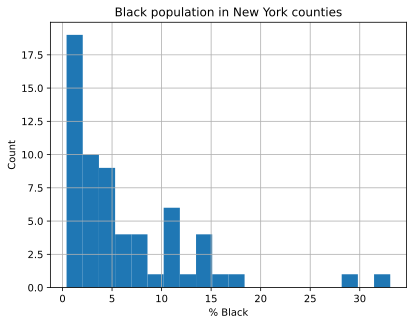

In [61]:
ax = race_df["black_pct"].hist(bins=20)
ax.set_xlabel("% Black")
ax.set_ylabel("Count")
ax.set_title("Black population in New York counties")
plt.show()

## Adding a dimension: Hispanic or Latino origin

The U.S. Census Bureau does not consider "Hispanic or Latino" a racial category; [rather, it is an ethnic category](https://www.census.gov/acs/www/about/why-we-ask-each-question/ethnicity/) ([this may change with the 2030 Census](https://www.npr.org/2023/01/26/1151608403/mena-race-categories-us-census-middle-eastern-latino-hispanic)). Hispanic or Latino origin and racial identification were therefore considered in separate questions on the 2020 Census questionnaire (if you're curious about the precise wording of the questions, see [this PDF of the questionnaire](https://www2.census.gov/programs-surveys/decennial/2020/technical-documentation/questionnaires-and-instructions/questionnaires/2020-informational-questionnaire-english_DI-Q1.pdf)).

[Table P2](https://data.census.gov/table/DECENNIALPL2020.P2?g=040XX00US36) contains population totals broken down by both race _and_ Hispanic/Latino origin. Let's retrieve county-level statistics from this table. (As with Table P1, column definitions are available in the [API documentation](https://api.census.gov/data/2020/dec/pl/variables.html).) When we rename columns derived from Table P2, **we'll use the prefix `nh_` for columns containing non-Hispanic population and the prefix `h_` for columns containing Hispanic population.**

In [64]:
p2_non_hispanic_population_columns = {
    "P2_005N": "nh_white",        # White alone
    "P2_006N": "nh_black",        # Black or African American alone
    "P2_007N": "nh_amin",         # American Indian and Alaska Native alone
    "P2_008N": "nh_asian",        # Asian alone
    "P2_009N": "nh_nhpi",         # Native Hawaiian and Other Pacific Islander alone
    "P2_010N": "nh_other",        # Some Other Race alone
    "P2_011N": "nh_two_or_more",  # Two or more races
}

In [66]:
county_non_hispanic_populations = census.pl.get(
    ("NAME", *p2_non_hispanic_population_columns),
    geo={
        "for": "county:*",
        "in": f"state:{state.fips}",
    }
)

In [67]:
race_ethnicity_df = pd.DataFrame(county_non_hispanic_populations)

In [68]:
race_ethnicity_df.head(5)

,NAME,P2_005N,P2_006N,P2_007N,P2_008N,P2_009N,P2_010N,P2_011N,state,county
0,"Albany County, New York",210895.0,40667.0,494.0,24363.0,166.0,1821.0,14847.0,36,001
1,"Allegany County, New York",42327.0,809.0,91.0,373.0,6.0,218.0,1667.0,36,003
2,"Bronx County, New York",130796.0,419393.0,3087.0,67766.0,457.0,16322.0,28370.0,36,005
3,"Broome County, New York",156173.0,11547.0,413.0,9337.0,64.0,864.0,10000.0,36,007
4,"Cattaraugus County, New York",67554.0,996.0,2661.0,560.0,9.0,212.0,3435.0,36,009


We can apply the same postprocessing steps we applied to Table P1 to clean up the column names.

In [70]:
race_ethnicity_df = race_ethnicity_df.rename(
    columns={"NAME": "name", **p2_non_hispanic_population_columns}
).drop(
    columns=["state", "county"]
).set_index("name")

In [73]:
race_ethnicity_df

,nh_white,nh_black,nh_amin,nh_asian,nh_nhpi,nh_other,nh_two_or_more
name,,,,,,,
"Albany County, New York",210895.0,40667.0,494.0,24363.0,166.0,1821.0,14847.0
"Allegany County, New York",42327.0,809.0,91.0,373.0,6.0,218.0,1667.0
"Bronx County, New York",130796.0,419393.0,3087.0,67766.0,457.0,16322.0,28370.0
"Broome County, New York",156173.0,11547.0,413.0,9337.0,64.0,864.0,10000.0
"Cattaraugus County, New York",67554.0,996.0,2661.0,560.0,9.0,212.0,3435.0
...,...,...,...,...,...,...,...
"Washington County, New York",54605.0,1563.0,149.0,319.0,22.0,143.0,2740.0
"Wayne County, New York",79230.0,2397.0,171.0,473.0,13.0,272.0,4213.0
"Westchester County, New York",497684.0,131010.0,1017.0,64907.0,150.0,8651.0,31704.0


Table P2 only includes _non_-Hispanic population by race, but we can easily derive Hispanic population by race by incorporating totals from Table P1.

In [78]:
for category in categories:
    race_ethnicity_df[f"h_{category}"] = race_df[category] - race_ethnicity_df[f"nh_{category}"]

In [80]:
race_ethnicity_df.head(5)

,nh_white,nh_black,nh_amin,nh_asian,nh_nhpi,nh_other,nh_two_or_more,h_white,h_black,h_amin,h_asian,h_nhpi,h_other,h_two_or_more
name,,,,,,,,,,,,,,
"Albany County, New York",210895.0,40667.0,494.0,24363.0,166.0,1821.0,14847.0,4601.0,2539.0,351.0,110.0,17.0,7052.0,6925.0
"Allegany County, New York",42327.0,809.0,91.0,373.0,6.0,218.0,1667.0,228.0,20.0,0.0,6.0,3.0,460.0,248.0
"Bronx County, New York",130796.0,419393.0,3087.0,67766.0,457.0,16322.0,28370.0,76777.0,67725.0,18452.0,1793.0,1183.0,476730.0,163803.0
"Broome County, New York",156173.0,11547.0,413.0,9337.0,64.0,864.0,10000.0,2501.0,1137.0,143.0,35.0,20.0,3111.0,3338.0
"Cattaraugus County, New York",67554.0,996.0,2661.0,560.0,9.0,212.0,3435.0,574.0,47.0,45.0,7.0,5.0,359.0,578.0


In [82]:
race_ethnicity_df["total"] = race_ethnicity_df.sum(axis=1)

In [84]:
non_hispanic_categories = list(p2_non_hispanic_population_columns.values())
non_hispanic_categories

['nh_white',
 'nh_black',
 'nh_amin',
 'nh_asian',
 'nh_nhpi',
 'nh_other',
 'nh_two_or_more']

For convenience, let's construct subtotals for the Hispanic and non-Hispanic populations.

In [87]:
race_ethnicity_df["nh_total"] = race_ethnicity_df[non_hispanic_categories].sum(axis=1)


In [89]:
hispanic_categories = [cat.replace("nh_", "h_") for cat in non_hispanic_categories]
hispanic_categories

['h_white',
 'h_black',
 'h_amin',
 'h_asian',
 'h_nhpi',
 'h_other',
 'h_two_or_more']

In [91]:
race_ethnicity_df["h_total"] = race_ethnicity_df[hispanic_categories].sum(axis=1)

In [93]:
race_ethnicity_df.head(5)

,nh_white,nh_black,nh_amin,nh_asian,nh_nhpi,nh_other,nh_two_or_more,h_white,h_black,h_amin,h_asian,h_nhpi,h_other,h_two_or_more,total,nh_total,h_total
name,,,,,,,,,,,,,,,,,
"Albany County, New York",210895.0,40667.0,494.0,24363.0,166.0,1821.0,14847.0,4601.0,2539.0,351.0,110.0,17.0,7052.0,6925.0,314848.0,293253.0,21595.0
"Allegany County, New York",42327.0,809.0,91.0,373.0,6.0,218.0,1667.0,228.0,20.0,0.0,6.0,3.0,460.0,248.0,46456.0,45491.0,965.0
"Bronx County, New York",130796.0,419393.0,3087.0,67766.0,457.0,16322.0,28370.0,76777.0,67725.0,18452.0,1793.0,1183.0,476730.0,163803.0,1472654.0,666191.0,806463.0
"Broome County, New York",156173.0,11547.0,413.0,9337.0,64.0,864.0,10000.0,2501.0,1137.0,143.0,35.0,20.0,3111.0,3338.0,198683.0,188398.0,10285.0
"Cattaraugus County, New York",67554.0,996.0,2661.0,560.0,9.0,212.0,3435.0,574.0,47.0,45.0,7.0,5.0,359.0,578.0,77042.0,75427.0,1615.0


It's always important to double-check our calculations. Here, we verify that the Hispanic and non-Hispanic totals add up to the overall population total in each county.

**Note: an [assert](https://docs.python.org/3/reference/simple_stmts.html) statement in Python is useful when de-bugging!** In this case, if the sum of your Hispanic and non-Hispanic populations does not add up to the total population, the assert will throw an error and you will not be able to run the code in this cell. This kind of behavior can be preferable if you want to ensure that certain conditions in your data are true and raise a noticeable error if they are not.

In [96]:
assert (race_ethnicity_df["h_total"] + race_ethnicity_df["nh_total"] == race_ethnicity_df["total"]).all()

Now that we've broken down the state population along two dimensions (race and Hispanic/Latino origin), we can answer some more sophisticated demographic questions: for instance, how does the distribution of racial identification differ between the Hispanic and non-Hispanic populations?

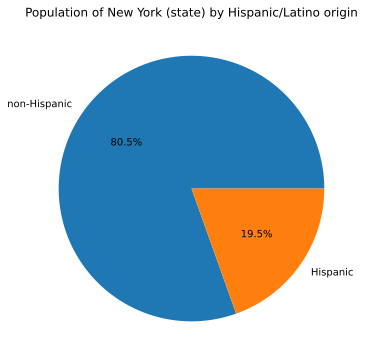

In [99]:
ax = race_ethnicity_df[["nh_total", "h_total"]].rename(
    columns={"nh_total": "non-Hispanic", "h_total": "Hispanic"}
).sum(axis=0).plot.pie(figsize=(6, 6), autopct="%1.1f%%")
ax.set_ylabel("")
ax.set_title(f"Population of {state} (state) by Hispanic/Latino origin")
plt.show()

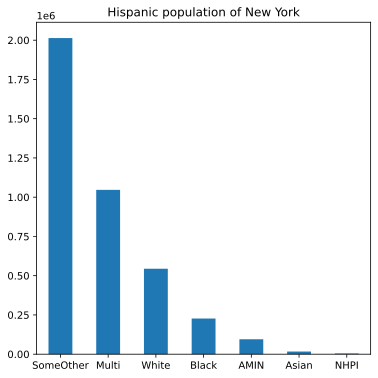

In [101]:
ax = race_ethnicity_df[hispanic_categories].rename(columns={
    "h_other": "SomeOther",
    "h_asian": "Asian",
    "h_black": "Black",
    "h_white": "White",
    "h_two_or_more": "Multi",
    "h_amin": "AMIN",
    "h_nhpi": "NHPI",
}).sum(axis=0).sort_values(ascending=False).plot.bar(figsize=(6, 6), rot=0)
ax.set_title(f"Hispanic population of {state}")
plt.show()

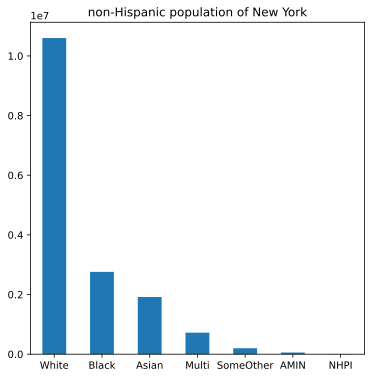

In [103]:
ax = race_ethnicity_df[non_hispanic_categories].rename(columns={
    "nh_other": "SomeOther",
    "nh_asian": "Asian",
    "nh_black": "Black",
    "nh_white": "White",
    "nh_two_or_more": "Multi",
    "nh_amin": "AMIN",
    "nh_nhpi": "NHPI",
}).sum(axis=0).sort_values(ascending=False).plot.bar(figsize=(6, 6), rot=0)
ax.set_title(f"non-Hispanic population of {state}")
plt.show()

## Homework 2, due Tuesday Feb 11, 1:25pm


For the **data product** part of your homework, explore the census race/ethnicity data.  Pose ONE question and show us a plot that answers it.  Here are some examples to get you thinking...
- How does the share of "white" people change in Texas if I only sort by race (ignoring ethnicity), or if I consider both race and ethnicity and treat Hispanic as a race?  (This could be a pair of pie charts side-by-side, for instance.)
- Which state had its number of multi-racial respondents jump most in absolute numbers between the 2010 and 2020 Census?
- What's the share of Hispanic respondents choosing "Some Other Race" in California? Is it very different from Florida?
- What's the Whitest state with at least 3 million people?
- Which state has the highest share of people who said they belong to ALL SIX races?  (note: to do this, you'd need to fetch new columns from the API)

Be creative!

For the **reading response** part of your homework, refer to the chapter by Nobles.  Pick out and quote one juicy sentence that you underlined when you read the chapter.  React to it and connect it to something from either Scott or Hacking (two other authors we've been discussing).

## My personal practice for mondays presentation 

In [237]:
#get all united states counties into one single table
uscounty_populations = census.pl.get(
    ("NAME", *p1_population_columns),
    geo={
        "for": "county:*",
        "in": f"state:*",
    }
)

#Make into a dataframe 
usrace_df = pd.DataFrame(uscounty_populations)


#rename columns 
usrace_df = usrace_df.rename(
    columns={"NAME": "name", **p1_population_columns}
).drop(
    columns=["state", "county"]
).set_index("name")
usrace_df.head(3)



,white,black,amin,asian,nhpi,other,two_or_more
name,,,,,,,
"Autauga County, Alabama",42160.0,11445.0,217.0,881.0,35.0,910.0,3157.0
"Baldwin County, Alabama",189399.0,18217.0,1582.0,2067.0,143.0,5335.0,15024.0
"Barbour County, Alabama",11317.0,11933.0,116.0,117.0,1.0,1039.0,700.0


In [239]:
usrace_df

,white,black,amin,asian,nhpi,other,two_or_more
name,,,,,,,
"Autauga County, Alabama",42160.0,11445.0,217.0,881.0,35.0,910.0,3157.0
"Baldwin County, Alabama",189399.0,18217.0,1582.0,2067.0,143.0,5335.0,15024.0
"Barbour County, Alabama",11317.0,11933.0,116.0,117.0,1.0,1039.0,700.0
"Bibb County, Alabama",16555.0,4413.0,60.0,32.0,9.0,465.0,759.0
"Blount County, Alabama",50663.0,845.0,337.0,178.0,24.0,3431.0,3656.0
...,...,...,...,...,...,...,...
"Renville County, Minnesota",13158.0,69.0,126.0,69.0,7.0,496.0,798.0
"Roseau County, Minnesota",13762.0,87.0,241.0,398.0,10.0,128.0,705.0
"Sherburne County, Minnesota",85504.0,3666.0,444.0,1295.0,22.0,1189.0,5063.0


In [241]:
#saves it to a list of decoded titles 
usp2_non_hispanic_population_columns = {
    "P2_005N": "nh_white",        # White alone
    "P2_006N": "nh_black",        # Black or African American alone
    "P2_007N": "nh_amin",         # American Indian and Alaska Native alone
    "P2_008N": "nh_asian",        # Asian alone
    "P2_009N": "nh_nhpi",         # Native Hawaiian and Other Pacific Islander alone
    "P2_010N": "nh_other",        # Some Other Race alone
    "P2_011N": "nh_two_or_more",  # Two or more races
}


#add hispanic 
uscounty_non_hispanic_populations = census.pl.get(
    ("NAME", *p2_non_hispanic_population_columns),
    geo={
        "for": "county:*",
        "in": f"state:*",
    }
)


#saves it to a dataframe
usrace_ethnicity_df = pd.DataFrame(uscounty_non_hispanic_populations)
#renaming the colums 
usrace_ethnicity_df = usrace_ethnicity_df.rename(
    columns={"NAME": "name", **p2_non_hispanic_population_columns}
).drop(
    columns=["state", "county"]
)

usrace_ethnicity_df


,name,nh_white,nh_black,nh_amin,nh_asian,nh_nhpi,nh_other,nh_two_or_more
0,"Autauga County, Alabama",41582.0,11352.0,184.0,873.0,22.0,185.0,2490.0
1,"Baldwin County, Alabama",186495.0,18001.0,1291.0,2029.0,122.0,775.0,10368.0
2,"Barbour County, Alabama",11086.0,11850.0,58.0,103.0,0.0,63.0,553.0
3,"Bibb County, Alabama",16442.0,4390.0,39.0,26.0,9.0,47.0,600.0
4,"Blount County, Alabama",49764.0,826.0,188.0,174.0,11.0,100.0,2300.0
...,...,...,...,...,...,...,...,...
3216,"Renville County, Minnesota",12766.0,60.0,103.0,61.0,5.0,27.0,382.0
3217,"Roseau County, Minnesota",13700.0,85.0,229.0,398.0,10.0,56.0,615.0
3218,"Sherburne County, Minnesota",84761.0,3648.0,390.0,1277.0,22.0,313.0,3952.0
3219,"Steele County, Minnesota",31376.0,1359.0,65.0,330.0,18.0,58.0,1060.0


In [243]:
#create a column called state
usrace_ethnicity_df["state_name"]=usrace_ethnicity_df['name'].str.split(", ").str[1]

In [245]:
usrace_ethnicity_df

,name,nh_white,nh_black,nh_amin,nh_asian,nh_nhpi,nh_other,nh_two_or_more,state_name
0,"Autauga County, Alabama",41582.0,11352.0,184.0,873.0,22.0,185.0,2490.0,Alabama
1,"Baldwin County, Alabama",186495.0,18001.0,1291.0,2029.0,122.0,775.0,10368.0,Alabama
2,"Barbour County, Alabama",11086.0,11850.0,58.0,103.0,0.0,63.0,553.0,Alabama
3,"Bibb County, Alabama",16442.0,4390.0,39.0,26.0,9.0,47.0,600.0,Alabama
4,"Blount County, Alabama",49764.0,826.0,188.0,174.0,11.0,100.0,2300.0,Alabama
...,...,...,...,...,...,...,...,...,...
3216,"Renville County, Minnesota",12766.0,60.0,103.0,61.0,5.0,27.0,382.0,Minnesota
3217,"Roseau County, Minnesota",13700.0,85.0,229.0,398.0,10.0,56.0,615.0,Minnesota
3218,"Sherburne County, Minnesota",84761.0,3648.0,390.0,1277.0,22.0,313.0,3952.0,Minnesota
3219,"Steele County, Minnesota",31376.0,1359.0,65.0,330.0,18.0,58.0,1060.0,Minnesota


In [247]:
usrace_df.reset_index()

,name,white,black,amin,asian,nhpi,other,two_or_more
0,"Autauga County, Alabama",42160.0,11445.0,217.0,881.0,35.0,910.0,3157.0
1,"Baldwin County, Alabama",189399.0,18217.0,1582.0,2067.0,143.0,5335.0,15024.0
2,"Barbour County, Alabama",11317.0,11933.0,116.0,117.0,1.0,1039.0,700.0
3,"Bibb County, Alabama",16555.0,4413.0,60.0,32.0,9.0,465.0,759.0
4,"Blount County, Alabama",50663.0,845.0,337.0,178.0,24.0,3431.0,3656.0
...,...,...,...,...,...,...,...,...
3216,"Renville County, Minnesota",13158.0,69.0,126.0,69.0,7.0,496.0,798.0
3217,"Roseau County, Minnesota",13762.0,87.0,241.0,398.0,10.0,128.0,705.0
3218,"Sherburne County, Minnesota",85504.0,3666.0,444.0,1295.0,22.0,1189.0,5063.0
3219,"Steele County, Minnesota",32151.0,1373.0,120.0,342.0,22.0,1413.0,1985.0


In [259]:
merged_race_ethnicity_df = usrace_df.merge(usrace_ethnicity_df, how = 'inner', on = 'name')


In [261]:
merged_race_ethnicity_df

,name,white,black,amin,asian,nhpi,other,two_or_more,nh_white,nh_black,nh_amin,nh_asian,nh_nhpi,nh_other,nh_two_or_more,state_name
0,"Autauga County, Alabama",42160.0,11445.0,217.0,881.0,35.0,910.0,3157.0,41582.0,11352.0,184.0,873.0,22.0,185.0,2490.0,Alabama
1,"Baldwin County, Alabama",189399.0,18217.0,1582.0,2067.0,143.0,5335.0,15024.0,186495.0,18001.0,1291.0,2029.0,122.0,775.0,10368.0,Alabama
2,"Barbour County, Alabama",11317.0,11933.0,116.0,117.0,1.0,1039.0,700.0,11086.0,11850.0,58.0,103.0,0.0,63.0,553.0,Alabama
3,"Bibb County, Alabama",16555.0,4413.0,60.0,32.0,9.0,465.0,759.0,16442.0,4390.0,39.0,26.0,9.0,47.0,600.0,Alabama
4,"Blount County, Alabama",50663.0,845.0,337.0,178.0,24.0,3431.0,3656.0,49764.0,826.0,188.0,174.0,11.0,100.0,2300.0,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,"Renville County, Minnesota",13158.0,69.0,126.0,69.0,7.0,496.0,798.0,12766.0,60.0,103.0,61.0,5.0,27.0,382.0,Minnesota
3217,"Roseau County, Minnesota",13762.0,87.0,241.0,398.0,10.0,128.0,705.0,13700.0,85.0,229.0,398.0,10.0,56.0,615.0,Minnesota
3218,"Sherburne County, Minnesota",85504.0,3666.0,444.0,1295.0,22.0,1189.0,5063.0,84761.0,3648.0,390.0,1277.0,22.0,313.0,3952.0,Minnesota
3219,"Steele County, Minnesota",32151.0,1373.0,120.0,342.0,22.0,1413.0,1985.0,31376.0,1359.0,65.0,330.0,18.0,58.0,1060.0,Minnesota


In [267]:
#this adds the hispanic categories for all races 
for category in categories:
    merged_race_ethnicity_df[f"h_{category}"] = merged_race_ethnicity_df[category] - merged_race_ethnicity_df[f"nh_{category}"]

#adds total for the non hispanics so at this point we should have hispanic totals and non hispanc totals 
merged_race_ethnicity_df["nh_total"] = merged_race_ethnicity_df[non_hispanic_categories].sum(axis=1)


#hispanic totals 
merged_race_ethnicity_df["h_total"] = merged_race_ethnicity_df[hispanic_categories].sum(axis=1)

merged_race_ethnicity_df

,name,white,black,amin,asian,nhpi,other,two_or_more,nh_white,nh_black,...,state_name,h_white,h_black,h_amin,h_asian,h_nhpi,h_other,h_two_or_more,nh_total,h_total
0,"Autauga County, Alabama",42160.0,11445.0,217.0,881.0,35.0,910.0,3157.0,41582.0,11352.0,...,Alabama,578.0,93.0,33.0,8.0,13.0,725.0,667.0,56688.0,2117.0
1,"Baldwin County, Alabama",189399.0,18217.0,1582.0,2067.0,143.0,5335.0,15024.0,186495.0,18001.0,...,Alabama,2904.0,216.0,291.0,38.0,21.0,4560.0,4656.0,219081.0,12686.0
2,"Barbour County, Alabama",11317.0,11933.0,116.0,117.0,1.0,1039.0,700.0,11086.0,11850.0,...,Alabama,231.0,83.0,58.0,14.0,1.0,976.0,147.0,23713.0,1510.0
3,"Bibb County, Alabama",16555.0,4413.0,60.0,32.0,9.0,465.0,759.0,16442.0,4390.0,...,Alabama,113.0,23.0,21.0,6.0,0.0,418.0,159.0,21553.0,740.0
4,"Blount County, Alabama",50663.0,845.0,337.0,178.0,24.0,3431.0,3656.0,49764.0,826.0,...,Alabama,899.0,19.0,149.0,4.0,13.0,3331.0,1356.0,53363.0,5771.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,"Renville County, Minnesota",13158.0,69.0,126.0,69.0,7.0,496.0,798.0,12766.0,60.0,...,Minnesota,392.0,9.0,23.0,8.0,2.0,469.0,416.0,13404.0,1319.0
3217,"Roseau County, Minnesota",13762.0,87.0,241.0,398.0,10.0,128.0,705.0,13700.0,85.0,...,Minnesota,62.0,2.0,12.0,0.0,0.0,72.0,90.0,15093.0,238.0
3218,"Sherburne County, Minnesota",85504.0,3666.0,444.0,1295.0,22.0,1189.0,5063.0,84761.0,3648.0,...,Minnesota,743.0,18.0,54.0,18.0,0.0,876.0,1111.0,94363.0,2820.0
3219,"Steele County, Minnesota",32151.0,1373.0,120.0,342.0,22.0,1413.0,1985.0,31376.0,1359.0,...,Minnesota,775.0,14.0,55.0,12.0,4.0,1355.0,925.0,34266.0,3140.0


# Visualizations

In [113]:
#!curl -O https://web.archive.org/web/20241002004532if_/https://www2.census.gov/geo/tiger/TIGER2024/COUNTY/tl_2024_us_county.zip
!curl -O https://www2.census.gov/geo/tiger/TIGER2024/COUNTY/tl_2024_us_county.zip



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.0M  100 80.0M    0     0  11.3M      0  0:00:07  0:00:07 --:--:-- 13.0M


In [123]:
county_gdf = gpd.read_file("tl_2024_us_county.zip").set_index("GEOID")

In [145]:
county_gdf

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
GEOID,,,,,,,,,,,,,,,,,,
31039,31,039,00835841,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563042,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55525 41.82892, -96.55524 41.827..."
53069,53,069,01513275,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980773,61564428,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
35011,35,011,00933054,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818941,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
31109,31,109,00835876,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269508,22850511,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
31129,31,129,00835886,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645201,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,13,123,00351260,0500000US13123,Gilmer,Gilmer County,06,H1,G4020,None,None,None,A,1103804462,12337139,+34.6905232,-084.4548113,"POLYGON ((-84.30237 34.57832, -84.30329 34.577..."
27135,27,135,00659513,0500000US27135,Roseau,Roseau County,06,H1,G4020,None,None,None,A,4329782927,16924046,+48.7610683,-095.8215042,"POLYGON ((-95.25857 48.88666, -95.25707 48.885..."
28089,28,089,00695768,0500000US28089,Madison,Madison County,06,H1,G4020,298,27140,None,A,1849796735,72079469,+32.6343703,-090.0341603,"POLYGON ((-90.14883 32.40026, -90.14890 32.400..."


In [182]:
state_to_fips = {
    "Alabama": "01",
    "Alaska": "02",
    "Arizona": "04",
    "Arkansas": "05",
    "California": "06",
    "Colorado": "08",
    "Connecticut": "09",
    "Delaware": "10",
    "Florida": "12",
    "Georgia": "13",
    "Hawaii": "15",
    "Idaho": "16",
    "Illinois": "17",
    "Indiana": "18",
    "Iowa": "19",
    "Kansas": "20",
    "Kentucky": "21",
    "Louisiana": "22",
    "Maine": "23",
    "Maryland": "24",
    "Massachusetts": "25",
    "Michigan": "26",
    "Minnesota": "27",
    "Mississippi": "28",
    "Missouri": "29",
    "Montana": "30",
    "Nebraska": "31",
    "Nevada": "32",
    "New Hampshire": "33",
    "New Jersey": "34",
    "New Mexico": "35",
    "New York": "36",
    "North Carolina": "37",
    "North Dakota": "38",
    "Ohio": "39",
    "Oklahoma": "40",
    "Oregon": "41",
    "Pennsylvania": "42",
    "Rhode Island": "44",
    "South Carolina": "45",
    "South Dakota": "46",
    "Tennessee": "47",
    "Texas": "48",
    "Utah": "49",
    "Vermont": "50",
    "Virginia": "51",
    "Washington": "53",
    "West Virginia": "54",
    "Wisconsin": "55",
    "Wyoming": "56",
    "District of Columbia": "11"
}
